# Inverse Kinematics Simulation

In [2]:
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import math
import numpy as np

### Polar coordinate functions

In [3]:
def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

### Calculate end-joint values from xyz position

In [75]:
def normalize_degree(theta):
    # Normalizes degree theta from -1.5pi to 1.5pi
    multiplier = 1.5
    normalized_theta = theta % (math.pi * multiplier)
    
    # Maintain the negative sign if the original angle is negative
    if theta < 0:
        normalized_theta -= math.pi * multiplier

    # Return angle
    return normalized_theta

def get_joints_from_xyz_rel(x, y, z, rx=0, ry=0, rz=0, tool_offset=(0.145, 0, 0.14), initial_guess = (math.pi/2, math.pi/2, 0)):
    # Get limbs and offsets
    offset_x, offset_y, offset_z = tool_offset
    l_bs, l1, l2, l3 = (0.14, .422864, .359041, .15)

    # Calculate base angle and r relative to shoulder joint
    def calculate_theta(x, y, a):
        # Calculate if we need the + or - in our equations
        if (x>-a and y>=0) or (x>a and y<0):
            print('no flip')
            flip = 1
        elif (x<-a and y>=0) or (x<a and y<0):
            print('flip')
            flip = -1
        else: 
            print('critical')
            # Critical section (x=a, or x=-a). Infinite slope
            # Return 0 or 180 depending on sign
            return math.atan2(y, 0)
        
        # Calculate tangent line y = mx + b
        m = (x*y - math.sqrt(x*x*y*y-(x*x-a*a)*(y*y-a*a)))/(x*x-a*a)
        b = flip * a * math.sqrt(1+m*m)

        # Calculate equivalent tangent point on circle
        cx = (-flip*m*b)/(1+m*m)
        cy = m*cx + flip*b

        # Calculate base angle, make angle negative if flip=1
        theta = math.atan2(cy, cx) + (-math.pi if flip==1 else 0)

        return theta
    
    base_theta = calculate_theta(x, y, l_bs)
    cx, cy = l_bs*math.cos(base_theta), l_bs*math.sin(l_bs)
    r = math.sqrt((x-cx)**2 + (y-cy)**2) - 0.1


    # Formulas to find out joint positions for (r, z)
    def inv_kin_r_z(p):
        a, b, c = p            

        return (l1*math.cos(a) + l2*math.cos(a-b) + l3*math.cos(a-b-c) - r, # r
                l1*math.sin(a) + l2*math.sin(a-b) - l3*math.sin(a-b-c) - (z+offset_z),  # z
                a-b-c) # wrist angle


    # Normalize angles
    base, shoulder, elbow, wrist1 = [normalize_degree(deg) for deg in [base_theta, *fsolve(inv_kin_r_z, initial_guess)]]

    # Return result
    return base, shoulder, elbow, wrist1, ry, rz

def get_joints_from_xyz_abs(x, y, z):
    joints = get_joints_from_xyz_rel(x, y, z)

    # Joint offsets
    # Base, Shoulder, Elbow, Wrist
    inverse = [1, -1, 1, 1, 1, 1]
    offsets = [-math.pi/2, 0, 0, -math.pi/2, -math.pi/2, 0]

    # Return adjusted joint positions
    return [o+j*i for j, o, i in zip(joints, offsets, inverse)]

# print([math.degrees(deg) for deg in get_joints_from_xyz_rel(0.3, 0.3, 0.3)])
print([math.degrees(deg) for deg in get_joints_from_xyz_abs(0, -0.3, 0.1)])

flip
[62.18186071534606, -126.63734509021032, 142.6959710408549, -106.0586259506446]


In [64]:
def calculate_theta(x, y, a):
        # Calculate if we need the + or - in our equations
        if (x>a and y>=0) or (x>-a and y<0):
            print('no flip')
            flip = 1
        elif (x<a and y>=0) or (x<-a and y<0):
            print('flip')
            flip = -1
        else: 
            print('critical')
            # Critical section (x=a, or x=-a). Infinite slope
            # Return 0 or 180 depending on sign
            return math.atan2(y, 0)
        
        # Calculate tangent line y = mx + b
        m = (x*y + math.sqrt(x*x*y*y-(x*x-a*a)*(y*y-a*a)))/(x*x-a*a)
        b = flip * a * math.sqrt(1+m*m)

        # Calculate equivalent tangent point on circle
        cx = (-flip*m*b)/(1+m*m)
        cy = m*cx + flip*b

        # Calculate base angle
        theta = math.atan2(cy, cx) + (-math.pi if flip==1 else 0)

        return theta

calculate_theta(5,-5,1)

no flip


-126.86989764584402

### Simulate arm and joint angles

no flip
Target position (x,y,z): 0.3 0.3 0.3
Angles (base, shoulder, elbow, wrist): [-25.7322, 113.4225, 127.6133, -14.1908]
no flip
Robot Angles: [-115.7322, -113.4225, 127.6133, -104.1908]
elbow (x,y): -0.168 0.388
wrist (x,y): 0.18 0.3
tool  (x,y): 0.33 0.3


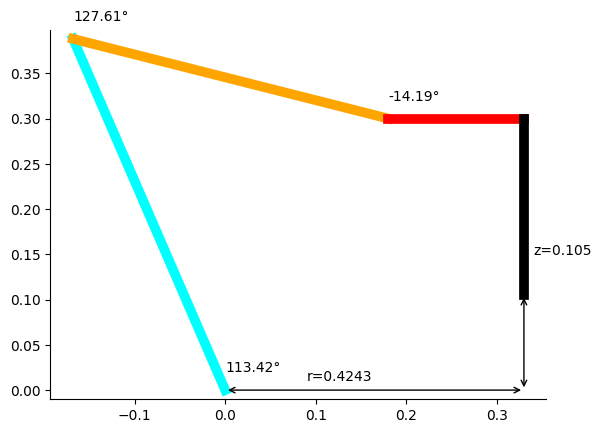

In [70]:
def draw_arm(x, y, z):

    # Get joint angles
    l1, l2, l3 = (.422864, .359041, .15)
    offset_x, offset_y, offset_z = (0.145, 0, 0.195)
    r, theta = cartesian_to_polar(x, y)
    base, shoulder, elbow, wrist = get_joints_from_xyz_rel(x, y, z)

    # Print angles
    print('Target position (x,y,z):', x, y, z)
    print('Angles (base, shoulder, elbow, wrist):', [round(math.degrees(i), 4) for i in [base, shoulder, elbow, wrist]])
    print('Robot Angles:', [round(math.degrees(i), 4) for i in get_joints_from_xyz_abs(x, y, z)])

    # Calculate each joint's endpoint position
    x1, y1 = polar_to_cartesian(l1, shoulder)
    x2, y2 = polar_to_cartesian(l2, shoulder-elbow)
    x2 += x1
    y2 += y1
    x3, y3 = polar_to_cartesian(l3, shoulder-elbow-wrist)
    x3 += x2
    y3 += y2 
    
    tx = x3
    ty = y3 - offset_z

    # Print each joint's endpoint position
    print('elbow (x,y):', round(x1,3), round(y1,3))
    print('wrist (x,y):', round(x2,3), round(y2,3))
    print('tool  (x,y):', round(x3,3), round(y3,3))

    # Draw limbs
    plt.plot([0, x1], [0, y1], color='cyan', linewidth=7)
    plt.plot([x1, x2], [y1, y2], color='orange', linewidth=7)
    plt.plot([x2, x2+l3], [y2, y2], color='red', linewidth=7)
    plt.plot()

    # Draw toolpoint
    plt.plot([x3, tx], [y3, ty], color='black', linewidth=7)

    # Display angles
    plt.text(0, 0.02, f'{round(math.degrees(shoulder), 2)}°')
    plt.text(x1, y1+0.02, f'{round(math.degrees(elbow), 2)}°')
    plt.text(x2, y2+0.02, f'{round(math.degrees(wrist), 2)}°')

    # Display r arrow
    plt.annotate(f'', xy=(0, 0), xycoords='data', xytext=(x3, 0), textcoords='data', arrowprops={'arrowstyle': '<->'})
    plt.annotate(f'r={round(r,4)}', xy=(x2/2, 0.01), xycoords='data', xytext=(x2/2, 0), textcoords='offset points')

    # Display z arrow
    plt.annotate(f'', xy=(x3, 0), xycoords='data', xytext=(tx, ty), textcoords='data', arrowprops={'arrowstyle': '<->'})
    plt.annotate(f'z={round(ty,4)}', xy=(x3+0.01, y2/2), xycoords='data', xytext=(x3/2, 0), textcoords='offset points')
   
    # Display plot
    ax = plt.subplot(111)
    ax.spines[['right', 'top']].set_visible(False)
    plt.axis('equal')
    plt.show()

draw_arm(0.3, 0.3, 0.3)

Target position (x,y,z): 0.3 0.3 0.3
Angles (base, shoulder, elbow, wrist): [33.9862, 85.2162, 73.3858, 11.8304]
Robot Angles: [33.9862, -85.2162, 73.3858, -78.1696]
elbow (x,y): 0.035 0.421
wrist (x,y): 0.387 0.495
tool  (x,y): 0.537 0.495


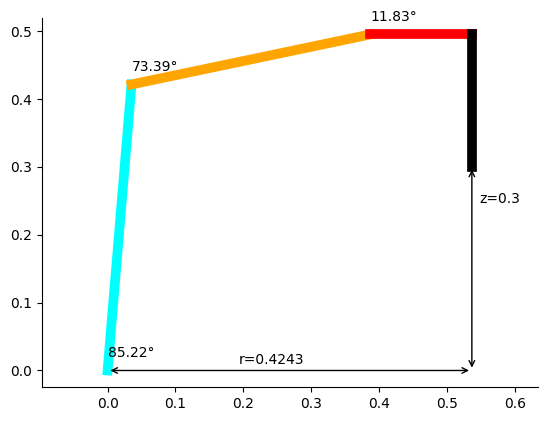

Target position (x,y,z): -0.3 -0.3 0.7
Angles (base, shoulder, elbow, wrist): [-117.3239, 78.0693, 0.0255, 79.0945]
Robot Angles: [-117.3239, -78.0693, 0.0255, -10.9055]
elbow (x,y): 0.087 0.414
wrist (x,y): 0.162 0.765
tool  (x,y): 0.312 0.762


c:\Users\nadee\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


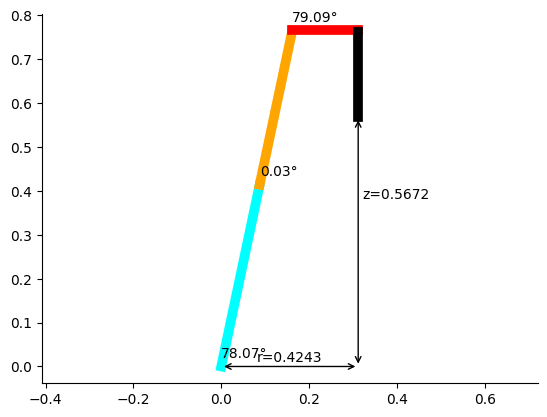

Target position (x,y,z): -0.3 0.4 0.2
Angles (base, shoulder, elbow, wrist): [111.1813, 100.8341, 104.0795, -3.2455]
Robot Angles: [111.1813, -100.8341, 104.0795, -93.2455]
elbow (x,y): -0.079 0.415
wrist (x,y): 0.279 0.395
tool  (x,y): 0.429 0.395


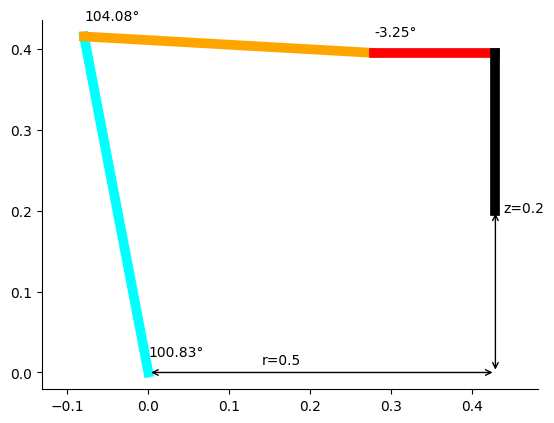

In [18]:
draw_arm(0.3, 0.3, 0.3)
draw_arm(-0.3, -0.3, 0.7)
draw_arm(-0.3, 0.4, 0.2)

## Interactive Arm

In [19]:
from ipywidgets import interact, FloatSlider

# Interactive slider for z coordinate
interact(draw_arm,  x=FloatSlider(min=0, max=1, step=0.01, value=0.3),
                    y=FloatSlider(min=0, max=1, step=0.01, value=0.3),
                    z=FloatSlider(min=0, max=1, step=0.01, value=0.3))


interactive(children=(FloatSlider(value=0.3, description='x', max=1.0, step=0.01), FloatSlider(value=0.3, desc…

<function __main__.draw_arm(x, y, z)>